In [124]:
# load the change in the files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

## Defining the forward diffusion process


In [126]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [127]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [128]:
import os
import sys
# append the parent directory to path
# sys.path.append('/home/miyen/diffusion-features/diffusion-features')
sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from utils.get_trajectories import get_trajectories
trajectories = get_trajectories()
trajectories = torch.tensor(trajectories, dtype=torch.float32)
print(trajectories.shape)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

/Users/sagarpatil/sagar/projects/diffusion-features/environment/data/lavaenv
torch.Size([1033, 64, 2])
torch.Size([1033, 64, 2])
tensor([[[1.0000, 4.0000],
         [1.0000, 4.0000],
         [1.0000, 3.7500],
         [1.0000, 3.5000],
         [1.0000, 3.2500],
         [1.0000, 3.0000],
         [1.0000, 2.7500],
         [1.0000, 2.5000],
         [1.0000, 2.2500],
         [1.0000, 2.0000],
         [1.2500, 2.0000],
         [1.5000, 2.0000],
         [1.7500, 2.0000],
         [2.0000, 2.0000],
         [2.2500, 2.0000],
         [2.5000, 2.0000],
         [2.7500, 2.0000],
         [3.0000, 2.0000],
         [3.2500, 2.0000],
         [3.5000, 2.0000],
         [3.7500, 2.0000],
         [4.0000, 2.0000],
         [4.2500, 2.0000],
         [4.5000, 2.0000],
         [4.7500, 2.0000],
         [5.0000, 2.0000],
         [5.2500, 2.0000],
         [5.5000, 2.0000],
         [5.7500, 2.0000],
         [6.0000, 2.0000],
         [6.2500, 2.0000],
         [6.5000, 2.0000],
       

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_22250/1557794813.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [129]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [130]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [131]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

torch.Size([1, 64, 2])
tensor([[[1.0093, 4.0022],
         [0.9861, 4.0101],
         [1.0053, 3.7521],
         [0.9910, 3.5017],
         [0.9961, 3.2503],
         [0.9902, 3.0046],
         [0.9880, 2.7494],
         [1.0022, 2.4902],
         [1.0042, 2.2385],
         [1.0196, 2.0028],
         [1.2482, 2.0060],
         [1.5074, 2.0077],
         [1.7461, 2.0262],
         [1.9878, 1.9917],
         [2.2446, 1.9964],
         [2.5004, 1.9877]]])


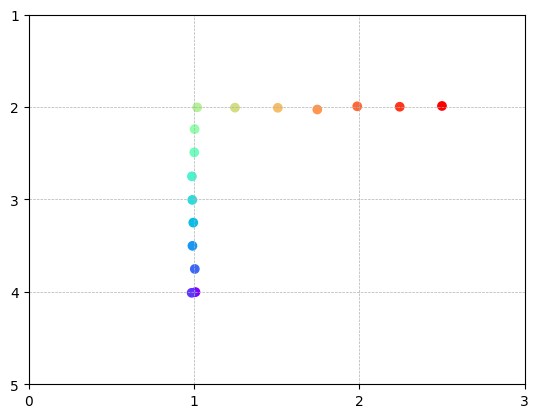

tensor([[[0.6655, 3.9468],
         [1.0631, 4.0966],
         [0.9537, 3.4919],
         [1.1176, 3.4780],
         [0.6607, 3.1483],
         [0.7471, 3.0537],
         [1.3612, 2.6826],
         [0.6501, 2.6618],
         [1.0176, 2.2578],
         [0.9608, 1.9689],
         [1.3234, 2.1683],
         [1.7703, 2.0074],
         [2.0372, 1.8895],
         [1.9559, 1.8734],
         [1.9349, 2.0416],
         [2.4290, 1.8727]]])


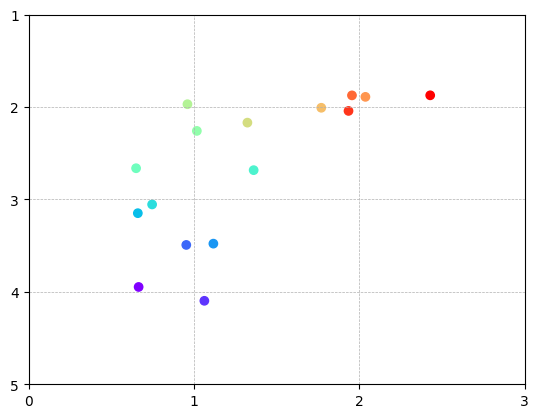

tensor([[[0.8893, 3.1392],
         [0.6865, 3.8347],
         [0.4895, 3.4251],
         [1.3064, 3.5328],
         [0.6033, 2.2263],
         [2.0012, 2.6726],
         [0.6796, 2.9782],
         [1.2633, 2.9430],
         [0.8972, 2.0082],
         [1.4132, 1.8437],
         [0.7446, 1.8113],
         [1.8942, 1.8008],
         [1.3854, 1.4101],
         [1.2963, 1.9972],
         [2.2001, 1.5620],
         [1.9010, 1.8964]]])


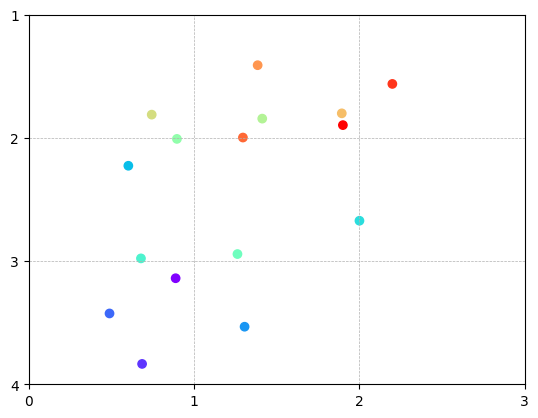

tensor([[[1.3288, 2.8775],
         [0.0878, 3.2653],
         [0.6190, 2.8358],
         [0.4732, 2.7735],
         [1.2227, 2.9947],
         [0.3465, 2.9567],
         [0.4787, 2.1844],
         [1.0978, 2.1034],
         [0.7373, 1.3553],
         [0.9962, 1.7649],
         [0.3879, 1.1748],
         [2.0444, 2.5509],
         [0.2462, 2.7957],
         [1.0869, 2.2958],
         [1.4775, 1.9487],
         [1.3045, 1.3657]]])


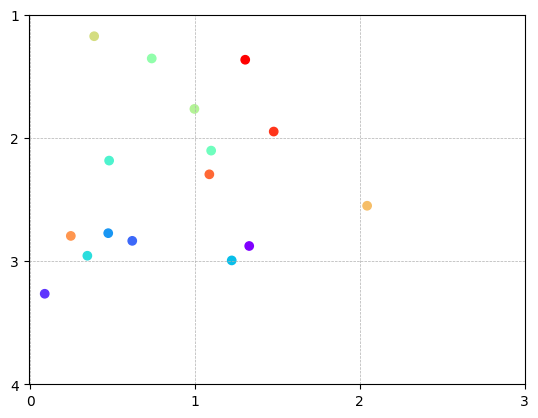

tensor([[[-0.6096,  1.6970],
         [ 2.0455,  1.7994],
         [-0.1344,  1.0060],
         [ 1.9534, -1.3854],
         [-1.5728,  1.0571],
         [ 0.0304, -0.1546],
         [ 0.5315,  0.7105],
         [-0.8201,  0.8895],
         [ 0.3076, -0.7277],
         [-0.6943,  0.3446],
         [ 0.8932,  1.5287],
         [-0.0033,  1.0953],
         [ 0.0879,  0.2091],
         [ 0.8971, -0.4833],
         [ 0.9177,  0.5680],
         [ 0.7412,  3.2426]]])


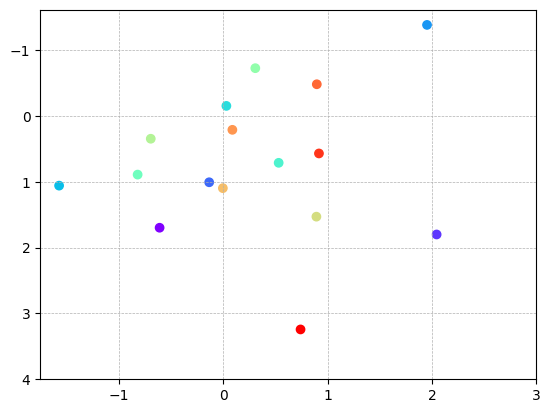

tensor([[[ 0.0664,  0.8808],
         [ 1.2274, -0.5066],
         [-1.7514, -0.4260],
         [ 0.1210,  1.2138],
         [ 0.3525, -0.6242],
         [-0.1806,  0.2469],
         [-1.1032, -0.3788],
         [ 0.1992, -1.4989],
         [-0.0254,  0.5968],
         [ 1.6603, -0.3913],
         [ 1.1349,  0.1331],
         [ 0.3010,  1.0749],
         [ 0.4638,  1.3422],
         [ 0.3498,  1.2599],
         [ 0.9058,  0.9364],
         [ 0.1464,  0.3388]]])


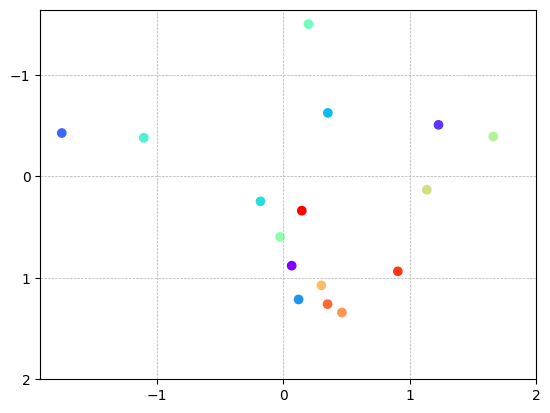

In [132]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start.shape)
# reduce the length of the trajectory to 16
x_start = x_start[:, :16, :]
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [133]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # print("x_noisy", x_noisy.shape)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [134]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [135]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [136]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        # print('emb shape:', emb.shape)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)
        # print('sample shape:', sample.shape)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            # print('x shape:', x.shape)
            # print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)
        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [137]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
# trajectories = trajectories[0:32]
trajectories = trajectories[:500]
# reduce the trajectory size to 16
trajectories = trajectories[:, :32, :]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=0,
    # global_cond_dim=4,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

torch.Size([500, 32, 2])


Let's start training!

In [138]:
# print the total number of trajectories
print(trajectories.shape)


torch.Size([500, 32, 2])


In [139]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 300
batch_size = 32
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
   loss_arr = []
   for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      # print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      start_states = batch[:, 0, :]
      end_states = batch[:, -1, :]
      condition = torch.cat((start_states, end_states), axis=1)
      # print(condition)
      condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      if b != batch_size:
         continue
      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      # print("Loss:", loss.item())
      
      loss_arr.append(loss.item())

      loss.backward()
      optimizer.step()
   print(f"Loss for epoch {epoch}: {np.mean(loss_arr)}")
      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_22250/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


Loss for epoch 0: 0.42782682180404663
Loss for epoch 1: 0.3057172695795695
Loss for epoch 2: 0.1857602636019389
Loss for epoch 3: 0.12363878786563873
Loss for epoch 4: 0.08884230901797613
Loss for epoch 5: 0.07919165641069412
Loss for epoch 6: 0.07195533489187558
Loss for epoch 7: 0.06269614696502686
Loss for epoch 8: 0.06191934943199158
Loss for epoch 9: 0.054688308387994766
Loss for epoch 10: 0.052166217813889186
Loss for epoch 11: 0.048526500910520555
Loss for epoch 12: 0.04836701874931653
Loss for epoch 13: 0.04732784430185954
Loss for epoch 14: 0.04614210948348045
Loss for epoch 15: 0.048468510061502455
Loss for epoch 16: 0.043208575000365575
Loss for epoch 17: 0.03566379025578499
Loss for epoch 18: 0.037916966279347736
Loss for epoch 19: 0.03785489574074745
Loss for epoch 20: 0.03510358768204848
Loss for epoch 21: 0.034476363286376
Loss for epoch 22: 0.03589919755856196
Loss for epoch 23: 0.03732731019457181
Loss for epoch 24: 0.03255581284562747
Loss for epoch 25: 0.033822866901

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [140]:
global_cond = torch.tensor([2, 2, 7, 4]).unsqueeze(0).to(device)
# convert condition to [-1, 1]
global_cond = (global_cond / 8) * 2 - 1
# print(global_cond)
global_cond = None
samples = sample_trajectories(model=model, traj_size=32, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_22250/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step: 100%|██████████| 500/500 [00:01<00:00, 468.68it/s]

500


(1, 32, 2)
[[[ 6.0686183   1.2743301 ]
  [ 8.5168705   6.24469   ]
  [ 0.20339489 -1.0595193 ]
  [ 5.0331745   1.0278857 ]
  [-1.6773791   7.0162497 ]
  [-1.1697254   3.4017434 ]
  [ 1.1621227  -1.0840354 ]
  [ 3.40095    10.184181  ]
  [ 0.24538183  5.830154  ]
  [-2.1133318   3.0295737 ]
  [ 0.7533157  -1.4850922 ]
  [-0.7000761  -2.037486  ]
  [11.899363   -1.1205688 ]
  [ 6.5226994   5.26852   ]
  [ 3.0339658   4.202957  ]
  [ 8.55616    -4.117996  ]
  [ 7.7357874   6.273234  ]
  [ 3.8003798   6.813035  ]
  [ 5.251063    2.5080934 ]
  [ 5.754706    0.4461794 ]
  [11.659914    3.2399416 ]
  [-3.2531667   6.567724  ]
  [-5.696745    0.9374151 ]
  [ 0.72984743  4.1043854 ]
  [ 4.5301347  10.098963  ]
  [ 4.014598    9.0113945 ]
  [-1.095983    1.0833561 ]
  [-0.95839787  4.228766  ]
  [-0.40778065  1.5420299 ]
  [ 0.5940542   2.96283   ]
  [ 1.834991   -0.06573057]
  [ 2.920866    2.4760566 ]]]


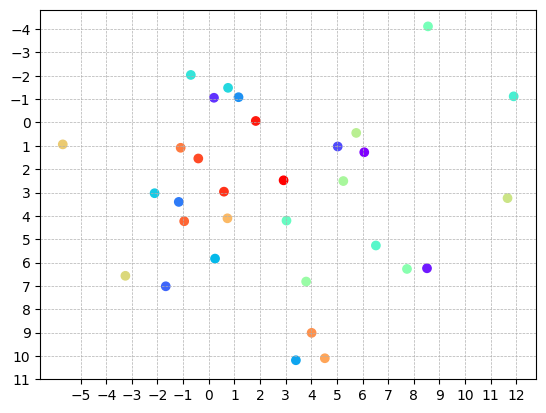

(1, 32, 2)
[[[ 9.921567    2.9142122 ]
  [ 9.731815    7.2743406 ]
  [ 0.9122126  -0.10085726]
  [ 4.6514664   5.8221555 ]
  [ 6.282484    9.235461  ]
  [ 5.249122    4.5559597 ]
  [ 6.7709646   2.5582633 ]
  [ 1.0469294   8.632458  ]
  [ 3.6128094   3.6779919 ]
  [-4.760953    5.332958  ]
  [ 2.024077   -5.214246  ]
  [-0.6230736   0.913491  ]
  [ 6.486246    4.325011  ]
  [11.447503   11.900334  ]
  [ 3.0052469   1.0916505 ]
  [ 5.0920873  -0.23081493]
  [10.488155    5.9678864 ]
  [ 2.525416    4.0148997 ]
  [ 4.3361998  -2.1854224 ]
  [ 3.230208    4.541565  ]
  [ 9.814999    5.4367075 ]
  [ 2.0535474   8.808003  ]
  [-0.51539755  2.526907  ]
  [-2.5622778   6.8605027 ]
  [ 6.8849773   7.838641  ]
  [ 2.8072782  10.290422  ]
  [ 3.9778094   6.5330467 ]
  [-0.7236943   6.0927    ]
  [-2.7150764   0.01393914]
  [-1.8090672  10.328299  ]
  [ 2.271271    2.602481  ]
  [ 0.751323   -1.8818269 ]]]


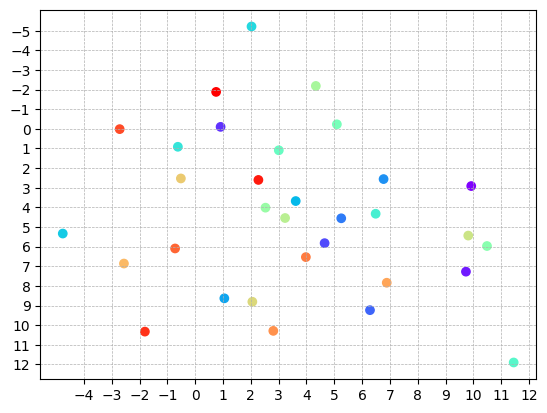

(1, 32, 2)
[[[ 6.2258205   3.9063203 ]
  [11.261089    4.0173826 ]
  [ 1.7272332   3.3680408 ]
  [ 2.7298937   4.518382  ]
  [ 2.564427    8.917889  ]
  [ 1.7806988   2.9435039 ]
  [ 5.6829557   7.3707523 ]
  [ 0.36030126  7.903203  ]
  [ 1.0307691   5.1610913 ]
  [-3.5598521  10.333536  ]
  [ 3.201303   -3.479813  ]
  [-1.9863739   1.1161213 ]
  [ 5.617409   -0.07029724]
  [12.023248    8.927626  ]
  [ 3.6081038   4.2183867 ]
  [ 7.4255147  -0.3619418 ]
  [ 9.269152    4.818217  ]
  [ 0.6298206   1.6639972 ]
  [ 6.489322   -0.94796896]
  [ 4.9576373   8.786791  ]
  [ 7.503682    2.814104  ]
  [ 4.5958304   8.343462  ]
  [-2.560588    0.5236726 ]
  [ 0.9130728   6.455127  ]
  [ 4.0515394   4.949888  ]
  [ 7.1895084   4.1440697 ]
  [ 4.982283    3.8058    ]
  [-0.24009895  7.8678036 ]
  [-0.33222914  1.6658623 ]
  [ 2.7490559   8.913429  ]
  [-0.4062686  -1.2464914 ]
  [-5.6125393  -6.941374  ]]]


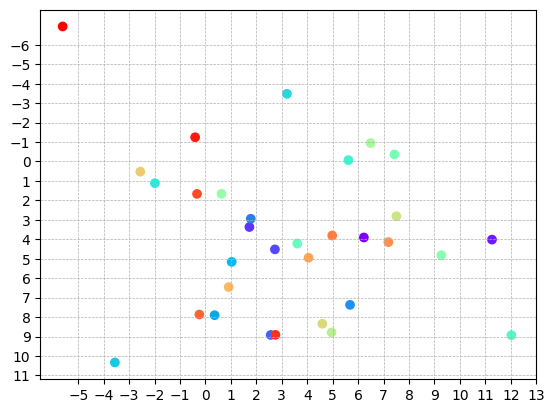

(1, 32, 2)
[[[ 8.745819    8.47513   ]
  [ 1.1724305   5.811306  ]
  [ 2.1168466   3.6535025 ]
  [ 7.953201    1.6170313 ]
  [ 3.624484   10.674484  ]
  [ 2.7651687   9.542961  ]
  [-0.6488013   9.730546  ]
  [ 1.1167853  11.973419  ]
  [ 0.5617492   0.3982792 ]
  [ 4.4640694   7.4890747 ]
  [ 0.9987483  -0.6023998 ]
  [ 1.0439458   2.4556282 ]
  [ 4.4557595   6.5390606 ]
  [ 1.3043485   3.0759883 ]
  [ 4.7752213   3.403482  ]
  [ 8.0703335  -0.45702505]
  [ 3.0642304  10.35906   ]
  [ 0.28186727  4.510861  ]
  [ 3.3813238   8.69681   ]
  [ 1.5562918   3.2246437 ]
  [10.285154   11.370309  ]
  [ 5.1642404   6.8144665 ]
  [ 2.993356    5.1575317 ]
  [ 0.97477174 10.057082  ]
  [ 9.247408    2.0253801 ]
  [-3.4396439   5.4190817 ]
  [ 4.276856    1.0562994 ]
  [ 4.6755776   4.2767377 ]
  [ 4.896937    4.9021196 ]
  [ 5.3662167   4.8218164 ]
  [ 4.585471   -5.436163  ]
  [-0.7295432  -8.4830675 ]]]


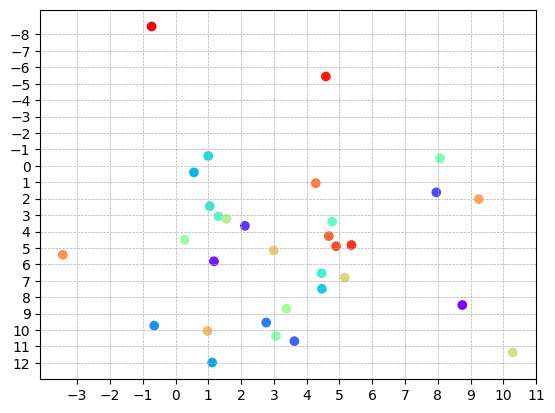

(1, 32, 2)
[[[ 1.6023328  6.0542965]
  [ 3.2942746  6.625434 ]
  [ 0.8060603  5.1330004]
  [ 4.251464   6.397995 ]
  [ 3.70226    4.402676 ]
  [ 3.2409883  9.281255 ]
  [ 3.1052716  5.74559  ]
  [ 2.817269   5.490213 ]
  [ 3.8080633  3.2814593]
  [ 2.7853572  9.029255 ]
  [ 2.8598948  6.187885 ]
  [ 2.2589588  6.8316917]
  [ 2.060314   5.2863135]
  [ 2.7762108  6.7685266]
  [ 3.4390295  7.877397 ]
  [ 4.278383   7.0469646]
  [ 2.7984538 10.015639 ]
  [ 3.474086   4.1503515]
  [ 1.2021427  6.078054 ]
  [ 4.266815   6.885356 ]
  [ 4.8445015  6.484805 ]
  [ 1.8359249  6.796143 ]
  [ 3.4439201  4.8143477]
  [ 2.2789412  6.042121 ]
  [ 1.9190078  4.802102 ]
  [ 0.9997556  4.8990364]
  [ 4.0907507  4.928986 ]
  [ 0.8440523  5.291945 ]
  [ 3.181232   3.615137 ]
  [ 5.0007935  5.231201 ]
  [ 1.7599432  6.0060434]
  [ 0.8688679  1.0108519]]]


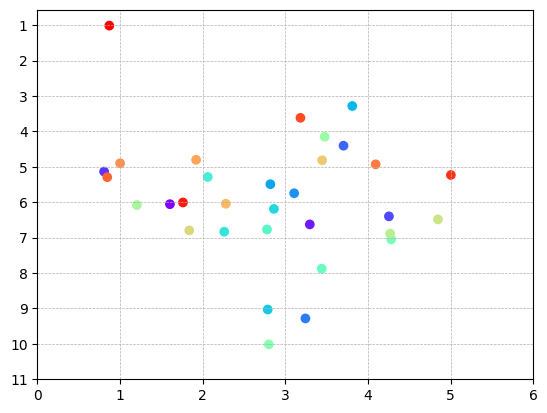

(1, 32, 2)
[[[2.5206442 7.3828187]
  [2.5505242 7.3659744]
  [2.5254097 7.4166627]
  [2.4883227 7.413786 ]
  [2.4389424 7.448324 ]
  [2.3820333 7.4520855]
  [2.3745513 7.4596705]
  [2.3313282 7.485719 ]
  [2.2784028 7.4800835]
  [2.2139044 7.458419 ]
  [2.126148  7.432046 ]
  [2.0580873 7.3428297]
  [2.2411509 7.329035 ]
  [2.4003282 7.2674847]
  [2.6103735 7.2419796]
  [2.7910728 7.165819 ]
  [2.9715328 7.150551 ]
  [3.0643463 7.032774 ]
  [3.2266645 6.941437 ]
  [3.3293    6.8113384]
  [3.402493  6.527301 ]
  [3.4438062 6.2444077]
  [3.4174612 5.9015403]
  [3.3786888 5.5798044]
  [3.2929492 5.3267593]
  [3.2564998 5.0643115]
  [3.2124605 4.804011 ]
  [3.1707213 4.5342193]
  [3.1801817 4.2834215]
  [3.2138631 3.989866 ]
  [3.3612175 3.7311244]
  [3.3826683 3.5274808]]]


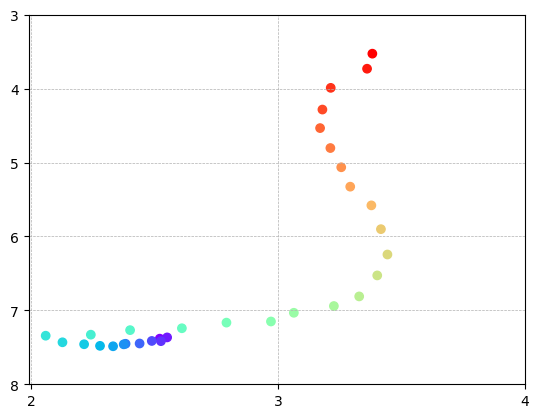

In [141]:
# show a random one
from utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i][:10])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />